 -  参考文献：Joel A. Tropp and Anna C. Gilbert 
 -  Signal Recovery From Random Measurements Via Orthogonal Matching
 -  Pursuit，IEEE TRANSACTIONS ON INFORMATION THEORY, VOL. 53, NO. 12,

In [1]:
import numpy as np
import math

In [2]:
def cs_omp(y,Phi,N,K):    
    residual=y  #初始化残差
    index=np.zeros(N,dtype=int)
    for i in range(N): #第i列被选中就是1，未选中就是-1
        index[i]= -1
    result=np.zeros((N,1))
    for j in range(K):  #迭代次数
        product=np.fabs(np.dot(Phi.T,residual))
        pos=np.argmax(product)  #最大投影系数对应的位置        
        index[pos]=1 #对应的位置取1
        my=np.linalg.pinv(Phi[:,index>=0]) #最小二乘          
        a=np.dot(my,y) #最小二乘,看参考文献1     
        residual=y-np.dot(Phi[:,index>=0],a)
    result[index>=0]=a
    Candidate = np.where(index>=0) #返回所有选中的列
    return  result, Candidate

In [3]:
# 单次实验
N = 256
M = 128
K = 20
# 生成稀疏信号（高斯）
x = np.random.randn(N,1)
x[:N-K]=0
np.random.shuffle(x)
# 生成高斯随机测量矩阵
Phi=np.random.randn(M,N)/np.sqrt(M)
# 观测信号
y = np.dot(Phi,x)
x_pre, Candidate = cs_omp(y,Phi,N,K)
print(Candidate)
error = np.linalg.norm(x-x_pre)/np.linalg.norm(x)
print(error)

(array([ 10,  14,  15,  21,  23,  24,  33,  52,  59,  61,  71,  86,  92,
       111, 125, 173, 176, 200, 214, 240], dtype=int64),)
2.614970542974584e-15


In [4]:
# 不同稀疏度下的重建概率
N = 256
M = 128
kk = np.linspace(1,60,60,dtype=np.int)
success_rate = np.zeros(60)
success_rate[0]=1
repeat = 200 
for k in kk:
    if k%10==0:
        print(k)
    for i in range(repeat):
        x = np.random.randn(N,1)
        x[:N-k]=0
        np.random.shuffle(x)
        Phi=np.random.randn(M,N)/np.sqrt(M)
        y = np.dot(Phi,x)
        x_pre, Candidate = cs_omp(y,Phi,N,k)
        error = np.linalg.norm(x-x_pre)/np.linalg.norm(x)
        if error < 1e-4:
            success_rate[k-1]+=1
    success_rate[k-1]/=repeat

10
20
30
40
50
60


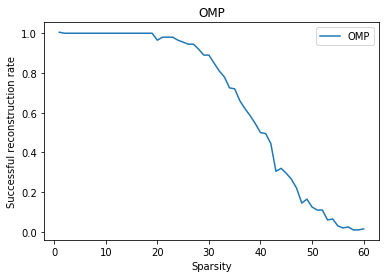

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(kk,success_rate,label='OMP')
plt.xlabel('Sparsity')
plt.ylabel('Successful reconstruction rate')
plt.title('OMP')
plt.legend()
plt.savefig('OMP.jpg')
plt.show()

In [6]:
#生成稀疏基DCT矩阵
mat_dct_1d=np.zeros((N,N))
v=range(N)
for k in range(0,N):  
    dct_1d=np.cos(np.dot(v,k*math.pi/N))
    if k>0:
        dct_1d=dct_1d-np.mean(dct_1d)
    mat_dct_1d[:,k]=dct_1d/np.linalg.norm(dct_1d)

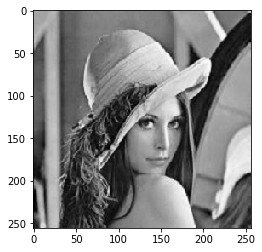

In [7]:
from PIL import Image
#读取图像，并变成numpy类型的 array
im = Image.open('imgs/lena.jpg').convert('L') #图片大小256*256
plt.imshow(im,cmap='gray')
N = 256
M = 128
K = 50
im = np.array(im)
# 观测矩阵
Phi=np.random.randn(M,N)/np.sqrt(M)
# 随机测量
img_cs_1d=np.dot(Phi,im)

In [8]:
# im_sparse = np.dot(np.linalg.pinv(mat_dct_1d),im)
# im_sparse = im_sparse[abs(im_sparse)>1]
# len(im_sparse)
# dct的稀疏率约为0.2

In [9]:
# 重建
sparse_rec_1d=np.zeros((N,N))   # 初始化稀疏系数矩阵    
Theta_1d=np.dot(Phi,mat_dct_1d)   #测量矩阵乘上基矩阵
for i in range(N):
    if i%32==0:
        print('正在重建第',i,'列。')
    y=np.reshape(img_cs_1d[:,i],(M,1))
    column_rec, Candidate=cs_omp(y,Theta_1d,N,K) #利用OMP算法计算稀疏系数
    x_pre = np.reshape(column_rec,(N))
    sparse_rec_1d[:,i]=x_pre

正在重建第 0 列。
正在重建第 32 列。
正在重建第 64 列。
正在重建第 96 列。
正在重建第 128 列。
正在重建第 160 列。
正在重建第 192 列。
正在重建第 224 列。


0.12850080715868828

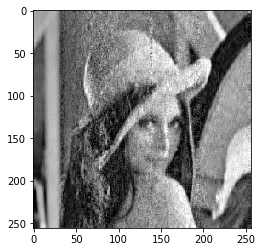

In [10]:
img_rec=np.dot(mat_dct_1d,sparse_rec_1d)          #稀疏系数乘上基矩阵
#显示重建后的图片
img_pre=Image.fromarray(img_rec)
plt.imshow(img_pre,cmap='gray')
error = np.linalg.norm(img_rec-im)/np.linalg.norm(im)
error